In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import *
from IPython.display import display, HTML, IFrame
%matplotlib inline
from collections import defaultdict
from IPython.display import set_matplotlib_formats
from bs4 import BeautifulSoup
set_matplotlib_formats('png','pdf')


In [2]:
folder = ['compsci-data','jbt-data', 'brands-data-400', 'brands-data-100', 'brands-data-it2','brands-data-it3', 'jbt-data-it2', 'compsci-data-it2']
MERGE_OTHER = True
ut = 'compsci'
#folder = ['brands-data-it2', '{}-data-it3'.format(ut), 'brands-data-400', 'brands-data-100']
#folder = ['{}-data'.format(ut), '{}-data-it2'.format(ut),'{}-data-it3'.format(ut)]

In [3]:
agg_list = []
full_list = []
test_list = []
for f in folder:
    print('### {}'.format(f))
    agg =  pd.read_csv('{}/agg.csv'.format(f))
    agg['type'] = f.split('-')[0]
    agg.set_index('id')
    agg_list.append(agg)
    print('Agg {}'.format(len(agg)))
   
    full = pd.read_csv('{}/full.csv'.format(f))
    full['type'] = f.split('-')[0]
    full.set_index('id')
    full_list.append( full)
    print('Full {}'.format(len(full)))
    
    test = pd.read_csv('{}/test.csv'.format(f))

    test = test[test['_hidden'] == False]
    test['type'] = f.split('-')[0]
    test.set_index('id')
    print('Test {}'.format(len(test)))
    test_list.append (test)
    
aggregated = pd.concat(agg_list)
if MERGE_OTHER:
    aggregated['label'] = aggregated.apply(lambda row: row['label'] if row['label'] != 'OTHER' else 'NONE', axis=1)
    full['label'] = full.apply(lambda row: row['label'] if row['label'] != 'OTHER' else 'NONE', axis=1)



full = pd.concat(full_list)
test_questions = pd.concat(test_list)

aggregated = aggregated[aggregated['_unit_state'] == 'finalized']
aggregated['raw_text'] = aggregated.apply(
        lambda row: BeautifulSoup(row['text_html'], "lxml").text.replace(':[OBJECT_A]', '').replace(':[OBJECT_B]', ''),
        axis=1)


def print_info(data):
    avg = pd.merge(data, full, suffixes=['_l', '_r'], on=['id'], how='left')[['id', 'text_readable_r', 'label:confidence', 'label_l', '_golden', 'label_r', '_trust','a','b']].sort_values(['label:confidence', 'label_l' ,'id'])
    renamed_avg = avg.rename(columns={'label_l' : 'assigned_by_crowdflower', 'label_r' : 'proposed_by_annotator'})
    renamed_avg
    return renamed_avg


### compsci-data
Agg 750
Full 2408
Test 53
### jbt-data
Agg 750
Full 2377
Test 51
### brands-data-400
Agg 650
Full 1990
Test 67
### brands-data-100
Agg 111
Full 328
Test 75
### brands-data-it2
Agg 1745
Full 5354
Test 60
### brands-data-it3
Agg 2422
Full 4772
Test 73
### jbt-data-it2
Agg 1713
Full 5139
Test 51
### compsci-data-it2
Agg 1719
Full 5181
Test 56


In [4]:
from datetime import datetime
print(datetime.now())
print('{} {}'.format(len(full['id'].unique()),len(aggregated['id'].unique())))
aggregated.rename(columns={"label":"old_label"})
aggregated['better_count'] = 0
aggregated['worse_count'] = 0
aggregated['none_count'] = 0
aggregated['judgements'] = 0
aggregated['label_winner_count'] = 0
aggregated['most_frequent_class'] = ''

rnd_cnt = 0
for i, row in full.iterrows():
    try:
        r_id = row['id']

        col = row['label'].lower() + '_count'
        if col == 'other_count':
            col = 'none_count'

        aggregated.loc[aggregated['id'] == r_id, col] += 1
        aggregated.loc[aggregated['id'] == r_id, 'judgements'] += 1
        m = [
            ('WORSE', aggregated.loc[aggregated['id'] == r_id, 'worse_count'].values[0]),
            ('BETTER',  aggregated.loc[aggregated['id'] == r_id, 'better_count'].values[0]),
            ('NONE',  aggregated.loc[aggregated['id'] == r_id, 'none_count'].values[0]),
        ]
        winner = sorted(m,key=lambda k: k[1], reverse=True)
        if winner[0][1] == winner[1][1]:
            if rnd_cnt % 2 == 0:
                aggregated.loc[aggregated['id'] == r_id, 'most_frequent_class'] = winner[0][0]
                aggregated.loc[aggregated['id'] == r_id, 'most_frequent_count'] = winner[0][1]
            else:
                aggregated.loc[aggregated['id'] == r_id, 'most_frequent_class'] = winner[1][0]
                aggregated.loc[aggregated['id'] == r_id, 'most_frequent_count'] = winner[1][1]
            rnd_cnt += 1
                
        else:
            aggregated.loc[aggregated['id'] == r_id, 'most_frequent_class'] = winner[0][0]
            aggregated.loc[aggregated['id'] == r_id, 'most_frequent_count'] = winner[0][1]
    except Exception as e:
        print(r_id, e)
        
aggregated.sort_values(['most_frequent_count'], ascending=False)
print(datetime.now())

2018-03-15 19:09:59.914676
7418 7413
J1469580416 index 0 is out of bounds for axis 0 with size 0
J1469580416 index 0 is out of bounds for axis 0 with size 0
P2597854130 index 0 is out of bounds for axis 0 with size 0
P2597854130 index 0 is out of bounds for axis 0 with size 0
O2345040275 index 0 is out of bounds for axis 0 with size 0
O2345040275 index 0 is out of bounds for axis 0 with size 0
O2288707396 index 0 is out of bounds for axis 0 with size 0
O2288707396 index 0 is out of bounds for axis 0 with size 0
E640214469 index 0 is out of bounds for axis 0 with size 0
E640214469 index 0 is out of bounds for axis 0 with size 0
2018-03-15 19:21:37.141088


In [5]:
dd= aggregated.drop_duplicates(subset=['id'])
dd[['id']].describe()
print('{} - without dups: {}'.format(len(aggregated),len(dd)))

# note: duplicates exist from the merge of the two rows (both rows still present)

dd['ratio'] =  dd['most_frequent_count']/dd['judgements']
certain = dd[dd['ratio'] > 0.5 ]
print('All: {} Certain: {}'.format(len(dd), len(dd[dd['ratio'] > 0.5 ])))
pd.set_option('display.max_colwidth', -1)

dd.columns

9775 - without dups: 7413
All: 7413 Certain: 7254


/Users/mirco/Documents/comparative-arguments/ve/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Index(['_golden', '_last_judgment_at', '_trusted_judgments', '_unit_id',
       '_unit_state', 'a', 'also_acceptable', 'b', 'expected_label',
       'gold_label', 'id', 'label', 'label:confidence', 'label_gold',
       'label_gold_reason', 'marker', 'orig__golden', 'raw_text', 'text_html',
       'text_readable', 'type', 'better_count', 'worse_count', 'none_count',
       'judgements', 'label_winner_count', 'most_frequent_class',
       'most_frequent_count', 'ratio'],
      dtype='object')

### Quality

In [6]:
conf = certain[['id','text_html', 'text_readable', 'label:confidence', 'label']]
display(conf[['label:confidence']].describe())
display(conf[['id', 'text_html']].describe())

,label:confidence
count,7254.000000
mean,0.906570
std,0.156711
min,0.335800
25%,0.705900
50%,1.000000
75%,1.000000
max,1.000000


,id,text_html
count,7254,7254
unique,7254,7254
top,N2223380108,"<span style=""color: #9A14B2; font-weight: bold"">Java:[OBJECT_A]</span>, <span style=""color: #6CB219; font-weight: bold"">Ruby:[OBJECT_B]</span>, python"
freq,1,1


In [7]:
import re
from collections import defaultdict
from pprint import pprint
import operator
d = defaultdict(int)
exp = r'[\w\s+*-]+(?=:\[OBJECT_[AB]\])'
s = set()
for i, row in certain.iterrows():
    a = (sorted(re.findall(exp, row['text_html'])))
    d['{} vs. {}'.format(a[0],a[1])] += 1
print(len(d))
pprint(sorted(d.items(), key=operator.itemgetter(1)))

273
[('B+ tree vs. B-tree', 1),
 ('foam vs. rubber', 2),
 ('foam vs. wood', 4),
 ('concrete vs. steel', 5),
 ('lumber vs. timber', 6),
 ('hockey vs. tennis', 6),
 ('concrete vs. rubber', 6),
 ('concrete vs. wood', 6),
 ('metal vs. plywood', 7),
 ('potato vs. steak', 7),
 ('georgia vs. michigan', 9),
 ('ds vs. ps3', 9),
 ('milk vs. tea', 9),
 ('chocolate vs. tea', 9),
 ('basketball vs. hockey', 9),
 ('football vs. tennis', 9),
 ('hockey vs. lacrosse', 9),
 ('forest vs. timber', 9),
 ('beer vs. champagne', 9),
 ('pistol vs. rifle', 9),
 ('pasta vs. pizza', 10),
 ('skiing vs. swimming', 10),
 ('ps2 vs. wii', 10),
 ('concrete vs. timber', 10),
 ('beer vs. milk', 10),
 ('motorcycle vs. truck', 10),
 ('cardboard vs. wood', 10),
 ('gamecube vs. ps2', 10),
 ('birthday vs. holiday', 10),
 ('kennedy vs. nixon', 10),
 ('bread vs. soup', 10),
 ('fishing vs. skiing', 10),
 ('steel vs. timber', 10),
 ('cardboard vs. plastic', 10),
 ('mobile vs. wallet', 11),
 ('concrete vs. plastic', 11),
 ('footbal

## Results

**Label Distribution**

In [8]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

def show_dist(labels):

    plt.figure(figsize=plt.figaspect(1))
    plt.pie(
        labels.value_counts().values,
        labels=labels.value_counts().keys().tolist(),
        radius=2,
        autopct=make_autopct(labels.value_counts().values))
    plt.show()


**All sentences**

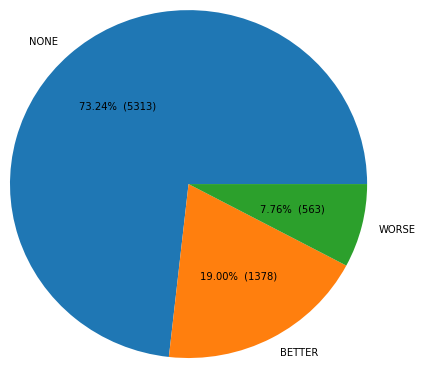

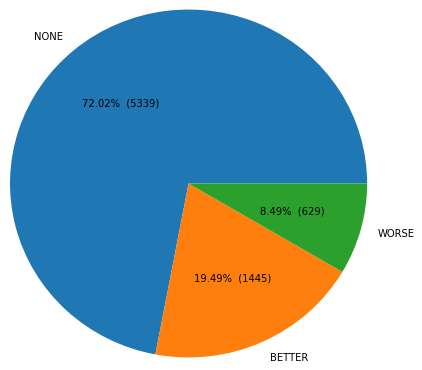

In [9]:
show_dist(certain['most_frequent_class'])
show_dist(dd['most_frequent_class'])

In [11]:
from sklearn.model_selection import train_test_split

train_i, test_i = train_test_split(dd,stratify=dd['most_frequent_class'], test_size=0.2,random_state=42)
print('{} {} {}'.format(len(train_i), len(test_i), (len(train_i)+ len(test_i))))
train_i.to_csv('data.csv')
test_i.to_csv('dev-data.csv')
print(train_i['_golden'].unique())
print(test_i['_golden'].unique())

5930 1483 7413
[False]
[False]


In [12]:
dd[['judgements']].sort_values('judgements')['judgements'].value_counts().sort_index()

2    1   
3    4695
4    339 
5    2199
6    161 
7    9   
8    9   
Name: judgements, dtype: int64

In [13]:
dd[['ratio']].sort_values('ratio')['ratio'].value_counts().sort_index()

0.333333    84  
0.400000    44  
0.500000    31  
0.600000    256 
0.625000    3   
0.666667    955 
0.714286    1   
0.750000    46  
0.800000    331 
0.833333    33  
0.857143    2   
0.875000    1   
1.000000    5626
Name: ratio, dtype: int64

In [14]:
print('More than 50% {} | Less {}'.format(len(dd[dd['ratio'] >= 0.5]),len(dd[dd['ratio'] <= 0.5])))

More than 50% 7285 | Less 159
